# Feature Selection
<hr style="height:1px;border:none;color:#333;background-color:#333;" />


## Table of Contents

* [1.1 Environment Setup](#env-setup)
    * [1.1.1 Importing Modules](#imports)
    * [1.1.2 Display Settings](#display-setup)
    * [1.1.3 Load Data](#read-file)
<br><br>
* [1.2 Exploratory Data Analysis](#eda)
    * [1.2.1 Grouping Variables by Type](#var-type)
    * [1.2.2 Remove Abnormal Sales](#ras)
    * [1.2.3 Combining Number Basement Bathrooms](#cnbb)
    * [1.2.4 Remove Numeric Features With Less Than 20% of Unique Observations](#rnf)
    * [1.2.5 Remove Nominal Variables With Less Than 10% of Unique Observations](#rnf)
    * [1.2.6 Converting Ordinal Variables to Numeric](#covn)
    * [1.2.7 Dummifying Nominal Variables](#dnr)
    * [1.2.8 Investigating MultiCollinearity: Correlation Matrix (continuous variables)](#imcm)
    * [1.2.9 Correlation Against Target Variable (SalePrice)](#catv)
    * [1.2.10 Checking for Normality: Dependent Variable](#cndv)
    * [1.2.11 Checking for Normality: Independent Variables](#cniv)
<br><br>
* [1.3 Feature Selection](#fs)
    * [1.3.1 Using Lasso Regression to Select Features](#lasso)
<br><br>
* [1.4 Descriptive Modeling](#dm)
    * [1.4.1 Train and Test data](#ttd)
    * [1.4.2 Multiple Linear Regression with all the features](#mlr)
    * [1.4.3 Multiple Linear Regresion with limited number of features](#mlr2)
    * [1.4.4 Evaluating p-values and R-squared using Statmodels](#statmodel)
    * [1.4.5 Further narrowing of the number of features](#fnnf)
<br><br>
* [1.5 Evaluating Overall Quality, Fence, and Roof](#eval-section)
    * [1.5.1 Roof Material](#roof-material)
    * [1.5.2 Fence Quality](#fence-quality)
    * [1.5.3 Overall Quality of the House](#overall-quality)

### 1.1 Environment Setup  <a class="anchor" id="env-setup"></a>

#### 1.1.1 Importing Modules<a class="anchor" id="imports"></a>

In [526]:
# import modules
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import warnings
import statsmodels.formula.api as smf
from scipy import stats
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")

#### 1.1.2 Display Settings<a class="anchor" id="display-setup"></a>

In [527]:
pd.set_option('display.max_columns', None) # display all the columns of a dataframe
pd.set_option('display.max_rows', 100)     # display 100 rows of a dataframe

#### 1.1.3 Load data<a class="anchor" id="read-file"></a>

In [528]:
# Load cleaned data - see "Data Cleansing.ipynb"
dataset = pd.read_csv('../ariel/Price_Data_cleaned.csv')

<br><br>
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

### 1.2 Exploratory Data Analysis <a class="anchor" id="eda"></a>

#### 1.2.1 Grouping Variables by Type<a class="anchor" id="var-type"></a>

In [529]:
continuous_variables = ['GrLivArea', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GarageArea', 'WoodDeckSF',
                       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
                       'SalePrice', 'LotFrontage']

discrete_variables = ['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
                      'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
                      'MoSold', 'YrSold']

nominal_variables = ['MSSubClass', 'Alley', 'LandContour', 'MSZoning', 'LotConfig', 'Neighborhood',
                     'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
                     'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Street', 'Heating',
                     'GarageType', 'CentralAir', 'MiscFeature', 'SaleType', 'SaleCondition']

ordinal_variables = ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                     'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC',
                     'GarageFinish', 'PavedDrive', 'Fence', 'Functional', 'BsmtFinType2', 'Electrical',
                     'BsmtFinType1','BsmtExposure', 'LandSlope', 'Utilities', 'LotShape',]


#### 1.2.2 Remove Abnormal Sales<a class="anchor" id="ras"></a>
<br>
Only include sales that were completed under 'normal' circumstances. The other type of sales (foreclosure, short sale, etc...) only account for 6% of the observations.

In [530]:
dataset = dataset[dataset['SaleCondition']=='Normal']

In [531]:
# Drop SaleCondition since all the sales are now 'Normal'
dataset.drop(columns='SaleCondition', inplace=True)

#### 1.2.3 Combining Number Basement Bathrooms<a class="anchor" id="cnbb"></a>

In [532]:
# Combine BsmtFullBath and BsmtHalfBath
dataset['BsmtNumBath'] = dataset['BsmtFullBath'] + dataset['BsmtHalfBath'] / dataset['BsmtHalfBath'].max()
# Total number of bathrooms above grade
dataset['TotalNumBath'] = dataset['FullBath'] + dataset['HalfBath'] / dataset['HalfBath'].max()
# Drop orginal features
dataset.drop(columns=['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath'], inplace=True)

#### 1.2.4 Remove Numeric Features With Less Than 20% of Unique Observations<a class="anchor" id="rnf"></a>

In [533]:
# Removing the following features since they are only present in less than 20% of the observations
((dataset.select_dtypes(['int','float'])==0).sum()/dataset.shape[0]).sort_values(ascending=False).head(10)


PoolArea         0.996270
3SsnPorch        0.988396
LowQualFinSF     0.987153
MiscVal          0.961044
ScreenPorch      0.912143
BsmtFinSF2       0.867799
EnclosedPorch    0.839619
MasVnrArea       0.615416
2ndFlrSF         0.562785
BsmtNumBath      0.522586
dtype: float64

In [534]:
dataset.drop(columns=['PoolArea', '3SsnPorch', 'LowQualFinSF', 'MiscVal','ScreenPorch','BsmtFinSF2','EnclosedPorch'], axis=1, inplace=True)

#### 1.2.5 Remove Nominal Variables With Less Than 10% of Unique Observations<a class="anchor" id="rnf"></a>

In [535]:
# Removing the following nominal variables since they are only present in less than 20% of the observations.
((dataset.select_dtypes('object')=='None').sum()/2413).sort_values(ascending=False).head(10)

PoolQC          0.996270
MiscFeature     0.960215
Alley           0.936179
Fence           0.791960
MasVnrType      0.618317
FireplaceQu     0.482387
GarageCond      0.048073
GarageQual      0.048073
GarageFinish    0.048073
GarageType      0.048073
dtype: float64

In [536]:
dataset.drop(columns=['PoolQC', 'MiscFeature', 'Alley'], axis=1, inplace=True)

#### 1.2.6 Converting Ordinal Variables to Numeric<a class="anchor" id="covn"></a>

In [537]:
# Encoding Ordinal Variables
dict_1 = {'None':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4}
dict_2 = {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
dict_3 = {'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}
dict_4 = {"None":0, "Unf":1, "RFn":2, "Fin":3}
dict_5 = {"N":1, "P":2, "Y":3}
dict_6 = {"None":0, "MnWw":1, "GdWo":2, "MnPrv":3, "GdPrv":4}
dict_7 = {"Sal":1, "Sev":2, "Maj2":3, "Maj1":4, "Mod":5, "Min2":6, "Min1":7, "Typ":8}
dict_8 = {"Mix":1, "FuseP":2, "FuseF":3, "FuseA":4, "SBrkr":5}
dict_9 = {"Sev":1, "Mod":2, "Gtl":3}
dict_10 = {"ELO":1, "NoSeWa":2, "NoSewr":3, "AllPub":4}
dict_11 = {"IR3":1, "IR2":2, "IR1":3, "Reg":4}

dataset.BsmtExposure.replace(dict_1, inplace=True)
dataset.ExterQual.replace(dict_2, inplace=True)
dataset.ExterCond.replace(dict_2, inplace=True)
dataset.BsmtQual.replace(dict_2, inplace=True)
dataset.BsmtCond.replace(dict_2, inplace=True)
dataset.HeatingQC.replace(dict_2, inplace=True)
dataset.KitchenQual.replace(dict_2, inplace=True)
dataset.FireplaceQu.replace(dict_2, inplace=True)
dataset.GarageQual.replace(dict_2, inplace=True)
dataset.GarageCond.replace(dict_2, inplace=True)
# dataset.PoolQC.replace(dict_2, inplace=True)
dataset.BsmtFinType1.replace(dict_3, inplace=True)
dataset.BsmtFinType2.replace(dict_3, inplace=True)
dataset.GarageFinish.replace(dict_4, inplace=True)
dataset.PavedDrive.replace(dict_5, inplace=True)
dataset.Fence.replace(dict_6, inplace=True)
dataset.Functional.replace(dict_7, inplace=True)
dataset.Electrical.replace(dict_8, inplace=True)
dataset.LandSlope.replace(dict_9, inplace=True)
dataset.Utilities.replace(dict_10, inplace=True)
dataset.LotShape.replace(dict_11, inplace=True)

#### 1.2.7 Dummifying Nominal Variables<a class="anchor" id="dnr"></a>

In [755]:
# update the nominal_variables list by removing the columns removed in the previous section
nominal_variables_updated = list(set(nominal_variables)-set(['PoolQC', 'MiscFeature', 'Alley', 'SaleCondition']))

In [756]:
# set the MSSubClass column to object, since it is a nominal variable
dataset['MSSubClass'] = dataset['MSSubClass'].astype(object)
# new dataset that will hold the encoded categorical variables + all the others
dataset_encoded = dataset.copy()
# Encode all categorical nominal variables
for column_name in nominal_variables_updated:
    dataset_encoded = pd.concat([dataset_encoded, pd.get_dummies(dataset_encoded[column_name], prefix=column_name, drop_first=True)], axis=1)
# Remove original categorical columns
dataset_encoded = dataset_encoded.drop(nominal_variables_updated, axis=1)

In [757]:
dataset_encoded

,GrLivArea,SalePrice,LotFrontage,LotArea,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,HeatingQC,Electrical,1stFlrSF,2ndFlrSF,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,Fence,MoSold,YrSold,BsmtNumBath,TotalNumBath,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_Oth,SaleType_VWD,SaleType_WD,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,LandContour_HLS,LandContour_Low,LandContour_Lvl,Street_Pave,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,CentralAir_Y,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,Exterior2nd_AsphShn,Exterior2nd_BrkComm,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CemntBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_WdShing,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190
0,856,126000,64.0,7890,4,4,3,6,6,1939,1950,0.0,3,3,3,3,1,3,238.0,1,618.0,856.0,3,5,856,0,2,1,3,4,8,1,4,1939.0,Unfinished,2.0,399.0,3,3,3,0,0,0,3,2010,1.0,1.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1049,139500,42.0,4235,4,4,3,5,5,1984,1984,149.0,4,3,4,3,2,6,552.0,5,104.0,1049.0,3,5,1049,0,2,1,4,5,8,0,0,1984.0,Finished,1.0,266.0,3,3,3,0,105,0,2,2009,1.0,2.0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

#### 1.2.8 Investigating MultiCollinearity: Correlation Matrix (continuous variables)<a class="anchor" id="imcm"></a>

In [540]:
continuous_variables_updated = list(set(continuous_variables)-set(['MiscVal', 'ScreenPorch', '3SsnPorch', 'LowQualFinSF', 'PoolArea','BsmtFinSF2','EnclosedPorch']))

In [541]:
# Generate correlation matrix (continues variables only)
corr_matrix = dataset[continuous_variables_updated].corr(method="pearson") # pearson? kendall? which is best

In [542]:
# List of highly (>0.85) correlated pair of variables
c_m = list(corr_matrix.columns)
for index_ in corr_matrix.columns:
    c_m.remove(index_)
    for feature in c_m:
        if abs(corr_matrix.loc[index_,feature])>0.85:
            print(index_,"_",feature,": ",corr_matrix.loc[index_,feature], sep="")

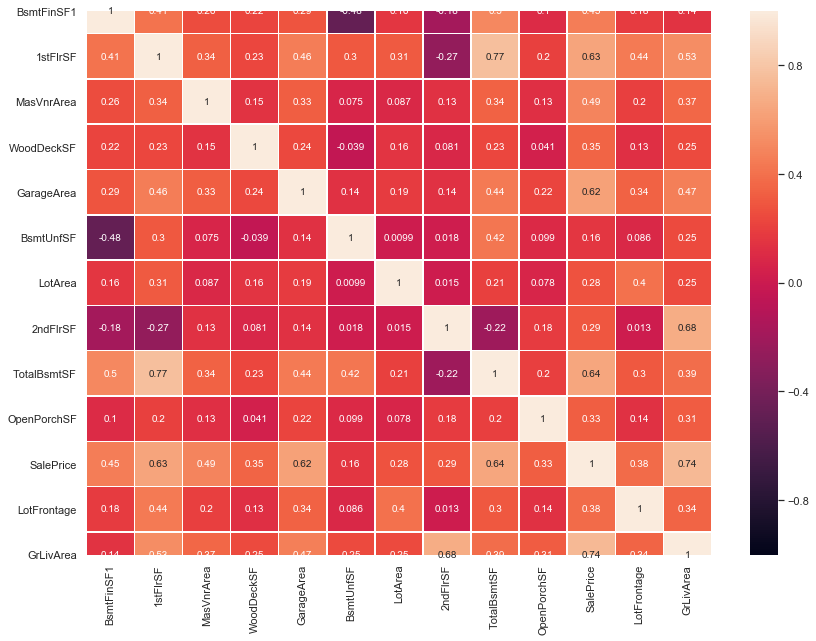

In [543]:
plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, linewidths=.5, annot=True)

<b>Conclusion:</b> correlation between features is within reasonable values, no feature will be removed.

#### 1.2.9 Correlation Against Target Variable (SalePrice)<a class="anchor" id="catv"></a>

In [544]:
# Remove features with low correlation (<0.01) with the target variable(SalePrice)
corr_matrix['SalePrice'].abs().sort_values(ascending=False)

SalePrice      1.000000
GrLivArea      0.736036
TotalBsmtSF    0.642354
1stFlrSF       0.634672
GarageArea     0.621900
MasVnrArea     0.486620
BsmtFinSF1     0.454087
LotFrontage    0.382420
WoodDeckSF     0.350127
OpenPorchSF    0.326489
2ndFlrSF       0.293338
LotArea        0.275066
BsmtUnfSF      0.159724
Name: SalePrice, dtype: float64

<b>Conslusion:</b> no features will be removed since correlation between target variable and features is within reasonable values.


#### 1.2.10 Checking for Normality: Dependent Variable<a class="anchor" id="cndv"></a>

variable = y
Median: 159000.0
Mean: 175567.64318276005
Skew: 1.7453580480340125
Kurtosis: 5.825763749688768
--------------------------------------------------
variable = log10(y)
Median: 5.201397124320452
Mean: 5.244444479212366
Skew: 0.24188453291963574
Kurtosis: 0.7653528688452214


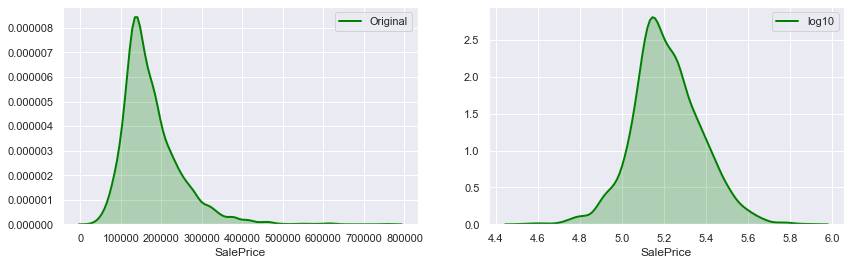

In [545]:
# Check Target variable for normal distribution
print('variable = y')
print("Median: " + str(dataset_encoded['SalePrice'].median()))
print("Mean: " + str(dataset_encoded['SalePrice'].mean()))
print("Skew: " + str(dataset_encoded['SalePrice'].skew()))
print("Kurtosis: " + str(dataset_encoded['SalePrice'].kurtosis()))
print("-"*50)
# log10
print("variable = log10(y)")
print("Median: " + str(np.log10(dataset_encoded['SalePrice'].median())))
print("Mean: " + str(np.log10(dataset_encoded['SalePrice'].mean())))
print("Skew: " + str(np.log10(dataset_encoded['SalePrice'].skew())))
print("Kurtosis: " + str(np.log10(dataset_encoded['SalePrice'].kurtosis())))
# creating axes to draw plots 
fig, ax = plt.subplots(1, 2, figsize=(14,4)) 
sns.distplot(dataset_encoded['SalePrice'], hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Original", color ="green", ax = ax[0]) 
sns.distplot(np.log10(dataset_encoded['SalePrice']), hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "log10", color ="green", ax = ax[1])


<b>Conclusion:</b> Calculating the log10 of the target variable produces a distribution closer to the normal distribution.

#### 1.2.11 Checking for Normality: Independent Variables<a class="anchor" id="cniv"></a>

In [546]:
# Continuous variables -> skewness
cont_var_skew = pd.DataFrame((dataset_encoded[continuous_variables_updated]).skew().abs()).reset_index()
cont_var_log_skew = pd.DataFrame(np.log10(dataset_encoded[continuous_variables_updated]+1).skew().abs()).reset_index()
cont_var_skew.columns = ['feature','skewness']
cont_var_log_skew.columns = ['feature','skewness_log']
cont_skew = cont_var_skew.merge(cont_var_log_skew, on="feature", how="inner")
cont_skew

,feature,skewness,skewness_log
0,BsmtFinSF1,0.746737,0.738851
1,1stFlrSF,1.043301,0.024600
2,MasVnrArea,2.750254,0.586703
3,WoodDeckSF,1.884156,0.156027
4,GarageArea,0.192519,3.738757
5,BsmtUnfSF,0.978891,2.129723
6,LotArea,13.393921,0.513180
7,2ndFlrSF,0.804118,0.269066
8,TotalBsmtSF,0.456386,4.948562
9,OpenPorchSF,2.269634,0.000086


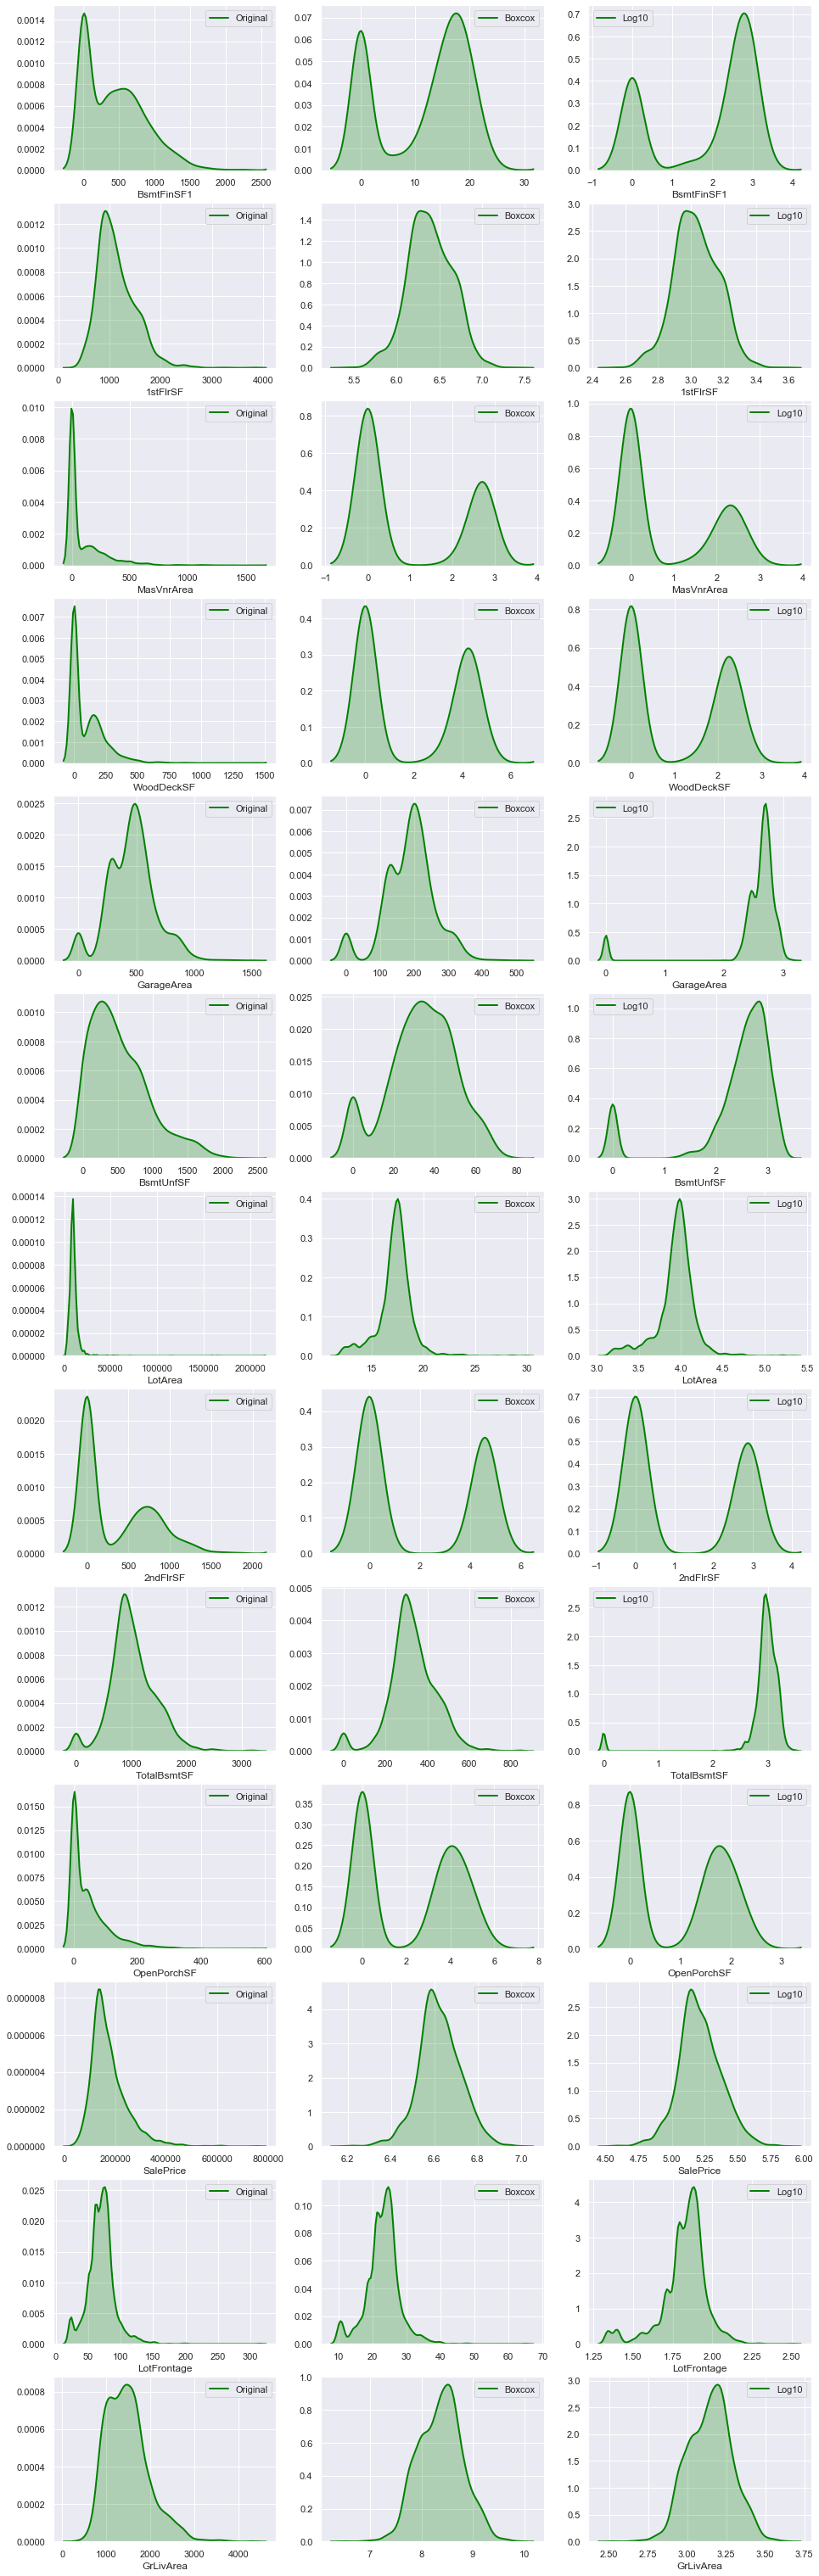

In [547]:
# creating axes to draw plots: 3 plots per feature
fig, ax = plt.subplots(dataset_encoded[continuous_variables_updated].shape[1], 3,  figsize=(16,55))
# Plot original data, boxcox, and log10
for i,feature in enumerate(continuous_variables_updated):
    original_data = dataset_encoded[feature]+1
    sns.distplot(original_data, hist = False, kde = True, 
                kde_kws = {'shade': True, 'linewidth': 2},  
                label = "Original", color ="green", ax = ax[i,0]) 

    fitted_data, fitted_lambda = stats.boxcox(original_data) 
    sns.distplot(fitted_data, hist = False, kde = True, 
                kde_kws = {'shade': True, 'linewidth': 2},  
                label = "Boxcox", color ="green", ax = ax[i,1]) 

    sns.distplot(np.log10(original_data), hist = False, kde = True, 
                kde_kws = {'shade': True, 'linewidth': 2},  
                label = "Log10", color ="green", ax = ax[i,2])

<b>Conclusion:</b> we will take the log10 of the following features: 1stFirSF, GrLivArea, and LotArea

In [548]:
# Take log10 of GrLivArea, LotArea, and 1stFlrSF
dataset_encoded['log10_GrLivArea'] = np.log10(dataset_encoded['GrLivArea'])
dataset_encoded['log10_LotArea'] = np.log10(dataset_encoded['LotArea'])
dataset_encoded['log10_1stFlrSF'] = np.log10(dataset_encoded['1stFlrSF']+1)     # +1 : This means we are adding bias, but is needed for zero
# Remove original columns
dataset_encoded.drop(columns=['GrLivArea','LotArea','1stFlrSF'], inplace=True)

<br><br>
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

### 1.3 Feature Selection<a class="anchor" id="fs"></a>

#### 1.3.1 Using Lasso Regression to Select Features<a class="anchor" id="lasso"></a>

In [549]:
X = dataset_encoded.drop('SalePrice',axis=1)  # features
y = dataset_encoded['SalePrice']              # target
X_norm = MinMaxScaler().fit_transform(X)      # Transform features by scaling each feature to a given range (0,1).

In [550]:
# Using Lasso to select features
clf = LassoCV(alphas=np.arange(0.0001, 0.01)).fit(X_norm, y)   # set alpha low to ensure the features will have more relevance
importance = np.abs(clf.coef_)

In [551]:
# create dataframe Feature - Importance
features =[]
scores = []
for i, feature in enumerate(X.columns):
    if importance[i]>0:
        features.append(feature)
        scores.append(importance[i])
# dataframe
feature_score = pd.DataFrame.from_dict({"feature":features,"Score":scores})

In [552]:
# top 20 features with highest importance value
lasso_generated_features = list(feature_score.sort_values(by="Score", ascending=False).head(20)['feature'])

<br><br>
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

### 1.4 Descriptive Modeling<a class="anchor" id="dm"></a>

#### 1.4.1 Train and Test data<a class="anchor" id="ttd"></a>

In [553]:
# dataset -> Includes all features - Ordinal features encoded, Nominal features not dummified.
# dataset_encoded.shape -> Includes all features - Ordinal and Nominal features encoded/dummified.
# X -> Same as dataset_encoded without SalePrice feature
# Y -> Same as dataset_encoded but only SalePrice feature
# X_norm -> Same as X but all the numerical values scaled (0,1)

In [554]:
# Split data 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=10)

#### 1.4.2 Multiple Linear Regression with all the features<a class="anchor" id="mlr"></a>

In [555]:
# Create model: Multiple Linear Regression
mlr_model = LinearRegression()
mlr_model.fit(X_train,np.log(y_train))

LinearRegression()

In [556]:
# # Calculate R-squared (score) using Training data
mlr_model.score(X_train,np.log(y_train))

0.9596248164084862

In [557]:
# Calculate R-squared (score) using Test data
mlr_model.score(X_test,np.log(y_test))

0.9353804149586203

#### 1.4.3 Multiple Linear Regresion with limited number of features<a class="anchor" id="mlr2"></a>

In [558]:
# Fit model with training data using Lasso generated features (top 20)
mlr_model.fit(X_train[lasso_generated_features], np.log10(y_train))
# Calculate R-squared (score) using training data
mlr_model.score(X_train[lasso_generated_features], np.log10(y_train))

0.9209162955514257

In [559]:
# Calculate R-squared (score) using test data
mlr_model.score(X_test[lasso_generated_features], np.log10(y_test))

0.9182176601933665

In [560]:
# Coefficients for features
for i, name_c in enumerate(lasso_generated_features):
    print(name_c +":  " + "{:.6f}". format(mlr_model.coef_[i]))

log10_1stFlrSF:  0.230083
TotalBsmtSF:  0.000079
Condition2_PosA:  0.043557
2ndFlrSF:  0.000081
Neighborhood_GrnHill:  0.164508
log10_LotArea:  0.109813
OverallQual:  0.037370
RoofMatl_WdShngl:  0.004379
Condition2_PosN:  0.050021
MasVnrArea:  0.000027
Exterior1st_PreCast:  0.175791
YearBuilt:  0.001531
GarageType_None:  -0.028972
log10_GrLivArea:  0.221022
OverallCond:  0.022255
Heating_OthW:  -0.044454
BsmtUnfSF:  -0.000041
BsmtCond:  0.006394
Condition2_RRAn:  0.000000
BedroomAbvGr:  -0.014778


#### 1.4.4 Evaluating p-values and R-squared using Statmodels<a class="anchor" id="statmodel"></a>

In [561]:
dataset_encoded.rename(columns={'2ndFlrSF':'FlrSF2nd'})

,SalePrice,LotFrontage,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,HeatingQC,Electrical,FlrSF2nd,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,Fence,MoSold,YrSold,BsmtNumBath,TotalNumBath,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_Oth,SaleType_VWD,SaleType_WD,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,LandContour_HLS,LandContour_Low,LandContour_Lvl,Street_Pave,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,CentralAir_Y,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,log10_GrLivArea,log10_LotArea,log10_1stFlrSF
0,126000,64.0,4,4,3,6,6,1939,1950,0.0,3,3,3,3,1,3,238.0,1,618.0,856.0,3,5,0,2,1,3,4,8,1,4,1939.0,1,2.0,399.0,3,3,3,0,0,0,3,2010,1.0,1.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.932474,3.897077,2.932981
1,139500,42.0,4,4,3,5,5,1984,1984,149.0,4,3,4,3,2,6,552.0,5,104.0,1049.0,3,5,0,2,1,4,5,8,0,0,1984.0,3,1.0,266.0,3,3,3,0,105,0,2,2009,1.0,2.0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [37]:
# Statmodels does not like feature names starting with a number
X_stat = dataset_encoded.rename(columns={'2ndFlrSF':'FlrSF2nd'})
y_stat = dataset['SalePrice']
# Split data 70/30
X_train_stat, X_test_stat, y_train_stat, y_test_stat = train_test_split(X_stat, y_stat, test_size=0.30, random_state=10)
smf_model_features = lasso_generated_features
smf_model_features[3] = 'FlrSF2nd'

In [38]:
# Fit regression model (using the natural log of one of the regressors)
results = smf.ols('np.log10(SalePrice) ~ ' + ' + '.join(smf_model_features), data=X_train_stat).fit()

# Inspect the results
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     np.log10(SalePrice)   R-squared:                       0.921
Model:                             OLS   Adj. R-squared:                  0.920
Method:                  Least Squares   F-statistic:                     1023.
Date:                 Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                         12:28:07   Log-Likelihood:                 2802.7
No. Observations:                 1689   AIC:                            -5565.
Df Residuals:                     1669   BIC:                            -5457.
Df Model:                           19                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             

In [39]:
# Decided to remove the following features whose Statistical Significance is low and some of the nominal features
smf_model_features = set(lasso_generated_features) - set(['Condition2_PosA','RoofMatl_WdShngl',
                                                          'Condition2_PosN','Heating_OthW','Condition2_RRAn'])#,'BsmtCond'])
                                                          #'Neighborhood_GrnHill','Exterior1st_PreCast','GarageType_None']) 

In [40]:
# Let's try again
# Fit regression model (using the natural log of one of the regressors)
results = smf.ols('np.log10(SalePrice) ~ ' + ' + '.join(smf_model_features), data=X_train_stat).fit()

# Inspect the results
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     np.log10(SalePrice)   R-squared:                       0.921
Model:                             OLS   Adj. R-squared:                  0.920
Method:                  Least Squares   F-statistic:                     1295.
Date:                 Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                         12:28:09   Log-Likelihood:                 2800.2
No. Observations:                 1689   AIC:                            -5568.
Df Residuals:                     1673   BIC:                            -5482.
Df Model:                           15                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             

# Evaluating Exterior
#### MasVnrType and MasVnrArea - Mason Veneer Type and Mason Veneer Area. Majority of Mason data is "None", therefore doesn't carry much significance. Exterior1st and Exterior2nd show similar result when the typos in Exterior 2nd were fixed - typos were: 'Wd Shng':'WdShing', 'CmentBd':'CemntBd', 'Brk Cmn':'BrkComm'

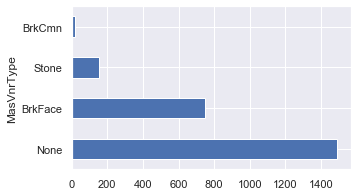

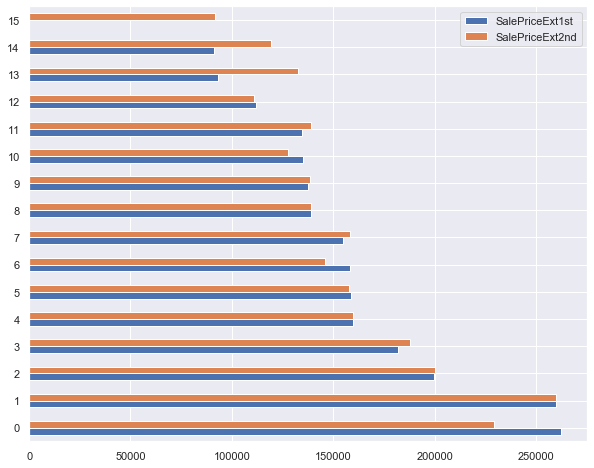

In [717]:
dataset.groupby('MasVnrType')['SalePrice'].count().sort_values(ascending=False).plot(kind = 'barh', figsize = (5,3))
dict_15 = {'Wd Shng':'WdShing', 'CmentBd':'CemntBd', 'Brk Cmn':'BrkComm'}
dataset.Exterior2nd.replace(dict_15, inplace=True)
Exterior1st = pd.DataFrame(dataset.groupby('Exterior1st')['SalePrice'].median().sort_values(ascending=False))\
.reset_index()
Exterior2nd = pd.DataFrame(dataset.groupby('Exterior2nd')['SalePrice'].median().sort_values(ascending=False))\
.reset_index()
df = pd.merge(Exterior1st, Exterior2nd, left_on = 'Exterior1st', right_on = 'Exterior2nd', how ='outer')
df.columns=['Exterior1st','SalePriceExt1st', 'Exterior2nd', 'SalePriceExt2nd']
df.plot(kind = 'barh', figsize = (10,8))

In [718]:
#Expanding the condensed Exterior names to their full names
exterior_dict = ({ 'AsbShng':'Asb Shingles','AsphShn':'Asph Shing','BrkComm':'Brick Common',\
                          'BrkFace':'Brick Face','CBlock':'Cinder Block','CemntBd':'Cement Board',\
                          'HdBoard':'Hard Board','ImStucc':'Imit Stucco','MetalSd':'Metal Siding',\
                          'Other':'Other','Plywood':'Plywood','PreCast':'PreCast','Stone':'Stone',
                          'Stucco':'Stucco','VinylSd':'Vinyl Siding','Wd Sdng':'Wood Siding',\
                          'WdShing':'Wood Shingles'})

In [719]:
# #Creating a dataset showing the Percentage of Houses that have this or that Exterior feature
# exterior_count = dataset.groupby(['Exterior2nd']).agg({"Exterior2nd":"count"})/dataset.shape[0]*100
# exterior_count.columns = ['Number of Houses']
# exterior_count.reset_index(inplace=True)
# exterior_count.columns=["Exterior2nd",'Percentage of Houses']
# exterior_count['Exterior2nd'].replace(exterior_dict, inplace=True)
# exterior_count.sort_values(['Percentage of Houses'],ascending=False).style.applymap(lambda x: 'color: red' if (x<1) else 'color: black', \
#                               subset=['Percentage of Houses']).hide_index()

In [720]:
#Dataset combining the Percentage of Houses and the mean SalePrice per feature
exterior_count = dataset.groupby(['Exterior2nd']).agg({"Exterior2nd":"count"})/dataset.shape[0]*100
exterior_count.columns = ['Number of Houses']
exterior_count.reset_index(inplace=True)
exterior_count.columns=["Exterior2nd",'Percentage of Houses']
exterior_count['Exterior2nd'].replace(exterior_dict, inplace=True)
exterior_count.sort_values(['Percentage of Houses'],ascending=False).style.applymap(lambda x: 'color: red' if (x<1) else 'color: black', \
                              subset=['Percentage of Houses']).hide_index()

exterior_count['Exterior2nd'].replace(exterior_dict, inplace=True)
exterSalePrice = pd.DataFrame(dataset.groupby('Exterior2nd')['SalePrice'].agg({'SalePrice':"mean"}).round(2)\
.sort_values(by="SalePrice", ascending=False)).reset_index()
exterSalePrice['Exterior2nd'].replace(exterior_dict, inplace=True)
exter_evaluated = pd.merge(exterSalePrice,exterior_count).sort_values(by='SalePrice',ascending=False)
exter_evaluated.sort_values(['SalePrice']).reset_index(drop=True)
exter_evaluated['Percentage of Houses']=exter_evaluated['Percentage of Houses'].round(2)

#### We selected to explore Exterior2nd feature deeper. The mean SalePrice per Exterior feature displayed on the left. The Percentage of Houses that have that Exterior material displayed on the right

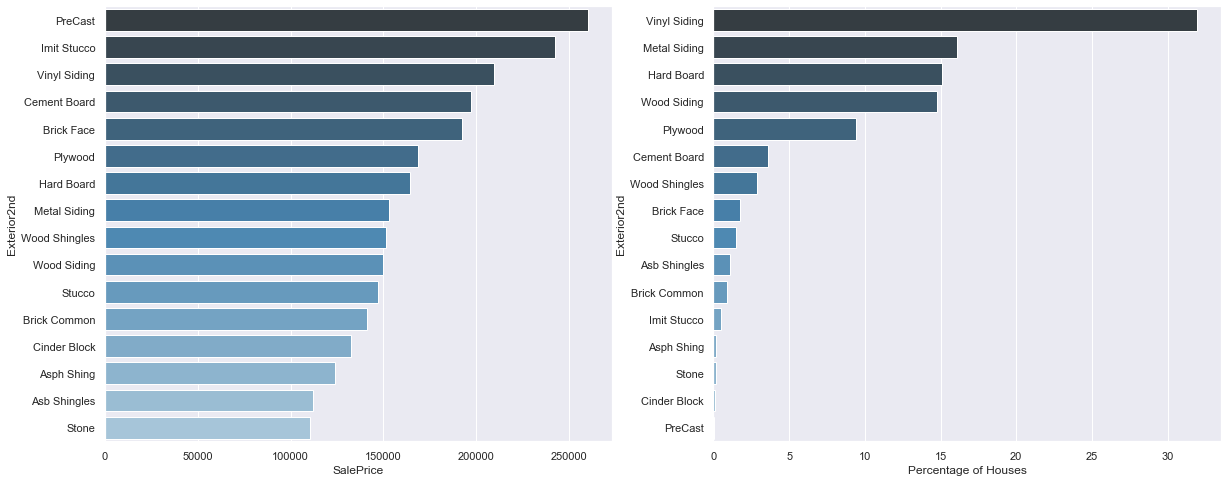

In [721]:
#Plotting 
import seaborn as sns
import itertools
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
sns.barplot(y="Exterior2nd", x="SalePrice", data=exter_evaluated, ax=ax1,palette="Blues_d")


exter_evaluated2=exter_evaluated.sort_values(['Percentage of Houses'],ascending=False).reset_index(drop=True)
sns.barplot(y="Exterior2nd",x="Percentage of Houses", data=exter_evaluated2,ax=ax2,palette="Blues_d")
plt.show();

In [722]:
df_exterior = pd.concat([dataset_encoded[['OverallQual', 'BedroomAbvGr', 'log10_GrLivArea', 'OverallCond',
                                      'YearBuilt', 'BsmtUnfSF', 'TotalBsmtSF','SalePrice',
                                      'log10_LotArea']],pd.get_dummies(dataset['Exterior2nd'])], axis=1)

In [723]:
# Remove observations for houses with ImStucc, Asphalt Shingles, Stone Cinder Block and Pre Cast. 
df_exterior.drop(index=df_exterior[(df_exterior['ImStucc']==1)].index[0], inplace=True)
df_exterior.drop(index=df_exterior[(df_exterior['AsphShn']==1)].index[0], inplace=True)
df_exterior.drop(index=df_exterior[(df_exterior['Stone']==1)].index[0], inplace=True)
df_exterior.drop(index=df_exterior[(df_exterior['CBlock']==1)].index[0], inplace=True)
df_exterior.drop(index=df_exterior[(df_exterior['PreCast']==1)].index[0], inplace=True)
df_exterior.drop(columns=['AsphShn','Stone','CBlock','PreCast'], inplace=True)

In [724]:
#Select 10 "Plywood" houses for our test
df_exterior_test = df_exterior[df_exterior['Plywood']==1].head(10)

In [725]:
 #grouped = dict(df.groupby("Exterior2st").size())
  #  df.Exterior2st = df.Exterior2st.apply(lambda x: 'Other' if lumped[x] < 20 else x)

#### We grab 10 houses with Plywood Exterior and use our model to predict the prices for these houses. Next, we predict the prices for these same houses if they had Vinyl Exterior instead of Plywood. Our model yields:

In [726]:
# Run the Model to evaluate Exterior material
mlr_model_exterior = LinearRegression()
mlr_model_exterior.fit(df_exterior.drop(columns=['SalePrice']), np.log10(df_exterior['SalePrice']))
mlr_model_exterior.score(df_exterior.drop(columns=['SalePrice']), np.log10(df_exterior['SalePrice']))

0.9158010328166403

In [728]:
#The price of the house with the exterior material "Plywood" combined with its coefficient
rows = []
for i in mlr_model_exterior.predict(df_exterior_test.drop(columns=['SalePrice'])):
    rows.append([i,round(10**i,2)])
Plywood = pd.DataFrame(rows, columns=["Plywood_coefs", "Price by Plywood"])

In [729]:
#The price of the same houses predicted with the exterior material "Vinyl" combined with its coefficient
df_exterior_test['VinylSd']=1
df_exterior_test['Plywood']=0
rows = []
for m in mlr_model_exterior.predict(df_exterior_test.drop(columns=['SalePrice'])):
    rows.append([m,round(10**m,2)])
Vinyl = pd.DataFrame(rows, columns=["Vinyl_coefs", "Price by Vinyl"])

In [730]:
#The houses and predicted prices if it was Plywood or Vinyl combined in the same dataset
Plywood_vs_Vinyl = Plywood.join(Vinyl, how='outer')
Plywood_vs_Vinyl['Difference'] = (Plywood_vs_Vinyl['Price by Vinyl'] - Plywood_vs_Vinyl['Price by Plywood'])
Plywood_vs_Vinyl.drop(['Plywood_coefs','Vinyl_coefs'], axis=1).sort_values(['Price by Vinyl'], ascending=False)
# Plywood_vs_Vinyl['Difference'] = list(map(lambda x,y: round((x/y)*100,1), Plywood_vs_Vinyl['Difference'],\
#                                           Plywood_vs_Vinyl['Price by Plywood']))
Plywood_vs_Vinyl['Plywood_coefs']=Plywood_vs_Vinyl['Plywood_coefs'].round(2)
Plywood_vs_Vinyl['Vinyl_coefs']=Plywood_vs_Vinyl['Vinyl_coefs'].round(2)

In [752]:
Plywood_vs_Vinyl.drop(['Plywood_coefs','Vinyl_coefs'],axis=1)

,Price by Plywood,Price by Vinyl,Difference
0,129287.19,134746.74,5459.55
1,156843.44,163466.64,6623.20
2,219061.00,228311.53,9250.53
3,188527.81,196488.98,7961.17
4,159762.70,166509.18,6746.48
5,149058.09,155352.53,6294.44
6,181585.60,189253.61,7668.01
7,124476.14,129732.53,5256.39
8,85087.79,88680.89,3593.10
9,141097.01,147055.27,5958.26


In [ ]:
#### Again, we compare the predicted value of the houses with Plywood Exterior with predicted value of the same houses if they had Vinyl exterior as opposed to Plywood. Each house with Plywood exterior shows an increase in price if it had Vinyl exterior

   Plywood_coefs  Price by Plywood  Vinyl_coefs  Price by Vinyl  Difference
0           5.11         129287.19         5.13       134746.74     5459.55
1           5.20         156843.44         5.21       163466.64     6623.20
2           5.34         219061.00         5.36       228311.53     9250.53
3           5.28         188527.81         5.29       196488.98     7961.17
4           5.20         159762.70         5.22       166509.18     6746.48
5           5.17         149058.09         5.19       155352.53     6294.44
6           5.26         181585.60         5.28       189253.61     7668.01
7           5.10         124476.14         5.11       129732.53     5256.39
8           4.93          85087.79         4.95        88680.89     3593.10
9           5.15         141097.01         5.17       147055.27     5958.26


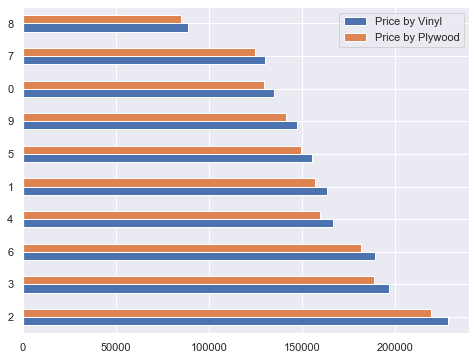

In [731]:
#The houses and predicted prices if it was Plywood or Vinyl combined in the same dataset and plotted
print(Plywood_vs_Vinyl)
Plywood_vs_Vinyl.sort_values(['Price by Vinyl'], ascending=False).plot(y=["Price by Vinyl","Price by Plywood"], kind="barh", figsize = (8,6))

In [733]:
garage = dataset[['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',\
                         'Neighborhood', "GrLivArea", "SalePrice",'GarageCond']]
garage1 = dataset[['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',\
                         'GarageCond']]

In [734]:
#This code was used to analyze Garage Quality and Condition but ultimately not needed for the analysis
#garage.groupby('GarageQual')['SalePrice'].count().sort_values(ascending=False)
#garage.groupby('GarageCond')['SalePrice'].count().sort_values(ascending=False)

In [737]:
#Analyzing Garage Finish - Interior Finish of a Garage
dict_4 = {0:'No Garage', 1:'Unfinished', 2:'Rough Fin', 3:'Finished'}
dataset.GarageFinish.replace(dict_4, inplace=True)

In [738]:
garagefinish_count = dataset.groupby(['GarageFinish']).agg({"GarageFinish":"count"})/dataset.shape[0]*100
garagefinish_count.columns = ['Number of Houses']
garagefinish_count.reset_index(inplace=True)
garagefinish_count.columns=["GarageFinish",'Percentage of Houses']
garagefinish_count
garagefinish_count['GarageFinish'].replace(dict_4, inplace=True)
garagefinish_count=garagefinish_count.style.applymap(lambda x: 'color: red' if (x<1) else 'color: black', \
                             subset=['Percentage of Houses']).hide_index()

In [739]:
garagefinish_count
garage_finish=pd.DataFrame(dataset.groupby(['GarageFinish'])['SalePrice']\
                                                                       .count()).reset_index()
#garage_finish=pd.merge(garagefinish_count,garagePerSalePrice, left_on='GarageFinish', right_on='GarageFinish',how='outer')
#garage_finish#.columns = ['GarageFinish','Count','SalePrice','GrLivArea']
# garage_finish.sort_values(by='SalePrice',ascending=False)

In [740]:
garagePerSalePrice = pd.DataFrame(dataset.groupby('GarageFinish').agg({"SalePrice":"mean"})\
.sort_values(by="SalePrice", ascending=False)).reset_index()

In [741]:
garage_finish_analyzed=pd.merge(garage_finish,garagePerSalePrice, left_on='GarageFinish', \
                                right_on='GarageFinish',how='outer')
garage_finish_analyzed.columns = ['GarageFinish','Count','SalePrice']
garage_finish_analyzed=garage_finish_analyzed.set_index('GarageFinish')
garage_finish_analyzed=garage_finish_analyzed.sort_values(by='SalePrice',ascending=False).reset_index()

### Evaluating Garage Finish
#### The count of Finished, Rough Finish, Unfinished and No Garage displayed on the left. The mean Sale Price for Finished, Rough Finish, Unfinished and No Garage displayed on the right

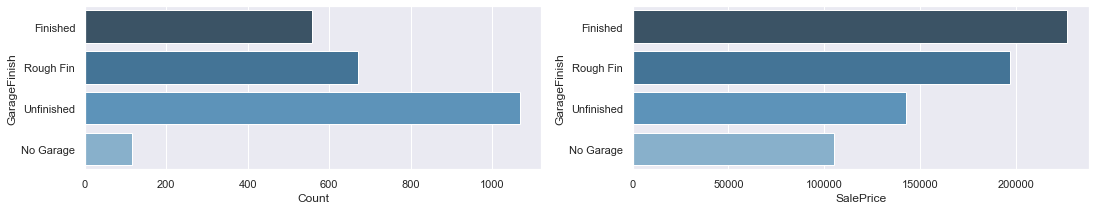

In [742]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,3))
sns.barplot(y="GarageFinish", x="Count", data=garage_finish_analyzed, ax=ax1,palette="Blues_d")

sns.barplot(y="GarageFinish",x="SalePrice", data=garage_finish_analyzed,ax=ax2,palette="Blues_d")
plt.show();

In [743]:
df_garage = pd.concat([dataset_encoded[['OverallQual', 'BedroomAbvGr', 'log10_GrLivArea', 'OverallCond',
                                      'YearBuilt', 'BsmtUnfSF', 'TotalBsmtSF','SalePrice',
                                      'log10_LotArea']],pd.get_dummies(dataset['GarageFinish'])], axis=1)

df_garage_test = df_garage[df_garage['Unfinished']==1].head(10)

In [ ]:
#### By the same logic we grab 10 houses with Unfinished Garage and use our model to predict the prices for these houses. Next, we predict the prices for these same houses if they had Finished Garage instead of Unfinished. Again, our model yields:

In [744]:
#Model to evaluate Garage Finish
mlr_model_garage = LinearRegression()
mlr_model_garage.fit(df_garage.drop(columns=['SalePrice']), np.log10(df_garage['SalePrice']))
mlr_model_garage.score(df_garage.drop(columns=['SalePrice']), np.log10(df_garage['SalePrice']))

0.9154034290784837

In [745]:
#Predict the prices of houses with garage finish staying the way it is
rows = []
for i in mlr_model_garage.predict(df_garage_test.drop(columns=['SalePrice'])):
    rows.append([i,round(10**i,2)])
  

Unfinished = pd.DataFrame(rows, columns=["Unfin_coefs", "Price for Unfin"]).sort_values(['Price for Unfin'], ascending=False)
Unfinished['Unfin_coefs']=Unfinished['Unfin_coefs'].round(2)

In [746]:
# Predict the sale price of a house if the garage is finished instead of unfinished
df_garage_test['Unfinished']=0
df_garage_test['Finished']=1
rows = []
for m in mlr_model_garage.predict(df_garage_test.drop(columns=['SalePrice'])):
    rows.append([m,round(10**m,2)])
    
Finished = pd.DataFrame(rows, columns=["Fin_coefs", "Price for Fin"]).sort_values(['Price for Fin'], ascending=False)
Unfinished_vs_Finished = Unfinished.join(Finished, how='outer')
Unfinished_vs_Finished['Difference'] = (Unfinished_vs_Finished['Price for Fin']- Unfinished_vs_Finished['Price for Unfin'])

In [754]:
Unfinished_vs_Finished.drop(['Unfin_coefs','Fin_coefs'],axis=1)

,Price for Unfin,Price for Fin,Difference
7,185629.90,190662.88,5032.98
9,150367.72,154444.64,4076.92
5,143491.54,147382.02,3890.48
4,132237.32,135822.67,3585.35
1,131259.17,134818.00,3558.83
0,113766.68,116851.23,3084.55
8,98434.30,101103.15,2668.85
2,96028.32,98631.94,2603.62
3,89853.38,92289.57,2436.19
6,87298.49,89665.41,2366.92


In [ ]:
#### Below are the coeffs and prices for houses with Unifinished Garages and predicted prices for the same houses if their garages were Finished. The houses are predicted to increase in price if their garages were Finished

   Unfin_coefs  Price for Unfin  Fin_coefs  Price for Fin  Difference
7         5.27        185629.90   5.280266      190662.88     5032.98
9         5.18        150367.72   5.188773      154444.64     4076.92
5         5.16        143491.54   5.168445      147382.02     3890.48
4         5.12        132237.32   5.132972      135822.67     3585.35
1         5.12        131259.17   5.129748      134818.00     3558.83
0         5.06        113766.68   5.067633      116851.23     3084.55
8         4.99         98434.30   5.004765      101103.15     2668.85
2         4.98         96028.32   4.994018       98631.94     2603.62
3         4.95         89853.38   4.965153       92289.57     2436.19
6         4.94         87298.49   4.952625       89665.41     2366.92


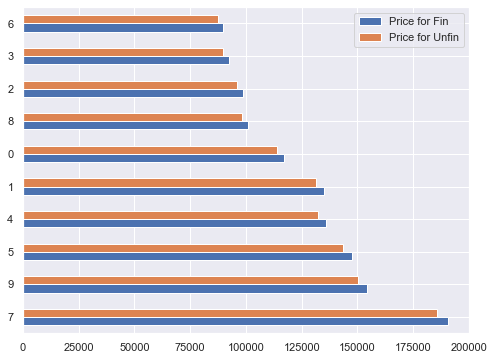

In [748]:
#The coefficients and prices for houses with Unifinished garages and 
#predicted prices for the same houses if their garages would be Finished
print(Unfinished_vs_Finished)
Unfinished_vs_Finished.plot(y=["Price for Fin","Price for Unfin"], kind="barh", figsize = (8,6))